# Constructing and training a convolutional neural network with human-like performance (>98%) on MNIST

Python notebook can be found at [https://github.com/sempwn/keras-intro](https://github.com/sempwn/keras-intro)

Before starting we'll need to make sure tensorflow and keras are installed. Open a terminal and type the following commands:
```sh
pip install --user tensorflow
pip install --user keras --upgrade
```

The back-end of keras can either use theano or tensorflow. Verify that keras will use tensorflow by using the following command:

```sh
sed -i 's/theano/tensorflow/g' $HOME/.keras/keras.json
```

In [1]:
%pylab inline
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Convolutional neural networks : A very brief introduction
To quote wikipedia:
> Convolutional neural networks are biologically inspired variants of multilayer perceptrons, designed to emulate the behaviour of a visual cortex. These models mitigate the challenges posed by the MLP architecture by exploiting the strong spatially local correlation present in natural images.

One principle in ML is to create a feature map for data and then use your favourite classifier on those features. For image data this might be presence of straight lines, curved lines, placement of holes etc. This strategy can be very problem dependent. Instead of having to feature engineer for each specific problem, it would be better to automatically generate the features and combine with the classifer. CNNs are a way to achieve this.

![image](http://cs231n.github.io/assets/cnn/depthcol.jpeg)
## Automatic feature engineering
Filters or convolution kernels can be treated like automatic feature detectors. A number of filters can be set before hand. For each filter, a convolution with this and part of the input is done for each part of the image. Weights for each filter are shared to reduce location dependency and reduce the number of parameters. The end result is a multi-dimensional matrix of copies of the original data with each filter applied to it.
![image2](http://cs231n.github.io/assets/nn1/neuron_model.jpeg)
For a classification task, after one or more convolutional layers a fully connected layer is applied. A Final layer with an output size equal to the number of classes is then added.

## Pooling
Once convolutions have been performed across the whole image, we need someway of down-sampling. The easiest and 
most common way is to perform max pooling. For a certain pool size return the maximum from the filtered image of that subset is given as the ouput. A diagram of this is shown below
![max pooling](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

In [2]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## Convolutions on image

Let's get some insight into what a random filter applied to a test image does. We'll compare this to the trained filters at the end.

Each filtered pixel in the image is defined by $C_i = \sum_j{I_{i+j-k} W_j}$, where $W$ is the filter (sometimes known as a kernel), $j$ is the 2D spatial index over $W$, $I$ is the input and $k$ is the coordinate of the center of $W$, specified by origin in the input parameters.

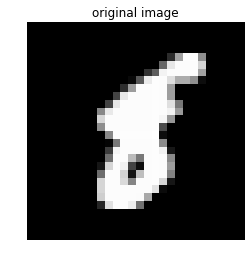

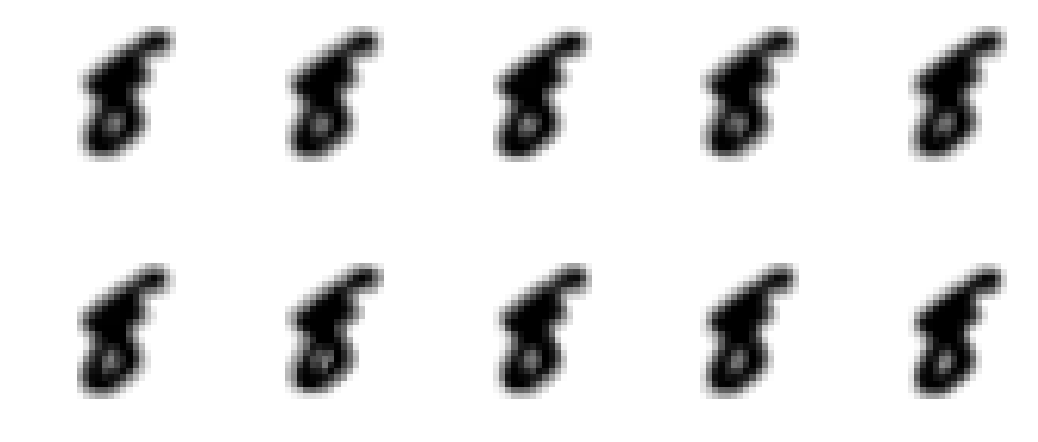

In [3]:
from scipy import signal
i = np.random.randint(x_train.shape[0])



c = x_train[i,:,:]
plt.imshow(c,cmap='gray'); plt.axis('off');
plt.title('original image');
plt.figure(figsize=(18,8))
for i in range(10):
    k = -1.0 + 1.0*np.random.rand(3,3)
    c_digit = signal.convolve2d(c, k, boundary='symm', mode='same');
    plt.subplot(2,5,i+1);
    plt.imshow(c_digit,cmap='gray'); plt.axis('off');



# Keras introduction
> Keras is a high-level neural networks API, written in Python and capable of running on top of either [TensorFlow](https://www.tensorflow.org) or [Theano](http://deeplearning.net/software/theano/). It was developed with a focus on enabling fast experimentation. 
> Being able to go from idea to result with the least possible delay is key to doing good research.

If you've used [scikit-learn](http://scikit-learn.org/stable/) then you should be on familiar ground as the library was developed with a similar philosophy.

 * Can use either theano or tensorflow as a back-end. For the most part, you just need to set it up and then interact with it using keras. Ordering of dimensions can be different though.
 * Models can be instaniated using the `Sequential()` class. 
 * Neural networks are built up from bottom layer to top using the `add()` method.
 * Lots of recipes to follow and many [examples](https://github.com/fchollet/keras/tree/master/examples) for problems in NLP and image classification.

In [4]:
batch_size = 128
nb_classes = 10
nb_epoch = 6

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

#sub-sample of test data to improve training speed. Comment out 
#if you want to train on full dataset.
x_train = x_train[:20000,:,:,:]
y_train = y_train[:20000]


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_test_inds = y_test.copy()
y_train_inds = y_train.copy()
y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test = keras.utils.to_categorical(y_test, nb_classes)

x_train shape: (20000, 28, 28, 1)
20000 train samples
10000 test samples


## One more trick to avoid overfitting
20000 data-points isn't a huge amount for the size of the models we're considering. 
* One trick to avoid overfitting is to use [drop-out](http://jmlr.org/papers/v15/srivastava14a.html). This is where a weight is randomly assigned zero with a given probability to avoid the model becoming too dependent on a small number of weights. 
* We can also consider [ridge](https://en.wikipedia.org/wiki/Tikhonov_regularization) or [LASSO](https://en.wikipedia.org/wiki/Lasso_%28statistics%29) regularisation as a way of trimming down the dependency and effective number of parameters.
* [Early stopping](https://en.wikipedia.org/wiki/Early_stopping) and [Batch Normalisation](https://arxiv.org/abs/1502.03167) are other strategies to help control over-fitting.

In [5]:
#Create sequential convolutional multi-layer perceptron with max pooling and dropout
#uncomment if you want to add more layers (in the interest of time we use a shallower model)
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) #nb_filters, 
#model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
#Let's see what we've constructed layer by layer
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 10000 samples
Epoch 1/6
20000/20000 [==============================] - 17s 831us/step - loss: 0.7008 - acc: 0.8039 - val_loss: 0.3120 - val_acc: 0.9123
Epoch 2/6
20000/20000 [==============================] - 16s 819us/step - loss: 0.3283 - acc: 0.9023 - val_loss: 0.2476 - val_acc: 0.9263
Epoch 3/6
20000/20000 [==============================] - 16s 825us/step - loss: 0.2652 - acc: 0.9220 - val_loss: 0.1936 - val_acc: 0.9444
Epoch 4/6
20000/20000 [==============================] - 17s 841us/step - loss: 0.2185 - acc: 0.9351 - val_loss: 0.1668 - val_acc: 0.9521
Epoch 5/6
20000/20000 [==============================] - 17s 870us/step - loss: 0.1873 - acc: 0.9465 - val_loss: 0.1408 - val_acc: 0.9606
Epoch 6/6
20000/20000 [==============================] - 17s 865us/step - loss: 0.1666 - acc: 0.9505 - val_loss: 0.1238 - val_acc: 0.9638
Test loss: 0.12384182169139385
Test accuracy: 0.9638


# Results
Let's take a random digit example to find out how confident the model is at classifying the correct category

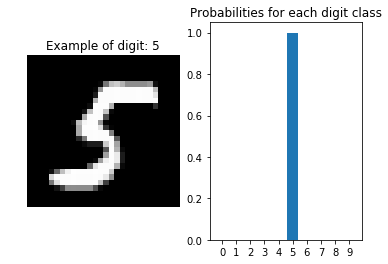

In [8]:
#choose a random data from test set and show probabilities for each class.
i = np.random.randint(0,len(x_test))
digit = x_test[i].reshape(28,28)

plt.figure();
plt.subplot(1,2,1);
plt.title('Example of digit: {}'.format(y_test_inds[i]));
plt.imshow(digit,cmap='gray'); plt.axis('off');
probs = model.predict_proba(digit.reshape(1,28,28,1),batch_size=1)
plt.subplot(1,2,2);
plt.title('Probabilities for each digit class');
plt.bar(np.arange(10),probs.reshape(10),align='center'); plt.xticks(np.arange(10),np.arange(10).astype(str));

## Wrong predictions
Let's look more closely at the predictions on the test data that weren't correct

In [9]:
predictions = model.predict_classes(x_test, batch_size=32, verbose=1)

10000/10000 [==============================] - 2s 225us/step


In [10]:
inds = np.arange(len(predictions))
wrong_results = inds[y_test_inds!=predictions]

## Example of an incorrectly labelled digit
We'll choose randomly from the test set a digit that was incorrectly labelled and then plot the probabilities predicted
for each class. We find that for an incorrectly labelled digit, the probabilities are in general lower and more spread between
classes than for a correctly labelled digit.

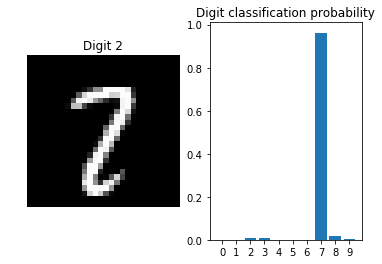

In [11]:
#choose a random wrong result from the test set
i = np.random.randint(0,len(wrong_results))
i = wrong_results[i]
digit = x_test[i].reshape(28,28)

plt.figure();

plt.subplot(1,2,1);
plt.title('Digit {}'.format(y_test_inds[i]));
plt.imshow(digit,cmap='gray'); plt.axis('off');
probs = model.predict_proba(digit.reshape(1,28,28,1),batch_size=1)
plt.subplot(1,2,2);
plt.title('Digit classification probability');
plt.bar(np.arange(10),probs.reshape(10),align='center'); plt.xticks(np.arange(10),np.arange(10).astype(str));

## Comparison between incorrectly labelled digits and all digits
It seems like for the example digit the prediction is a lot less confident when it's wrong. Is this always the case? Let's 
look at this by examining the maximum probability in any category for all digits that are incorrectly labelled.

In [12]:
prediction_probs = model.predict_proba(x_test, batch_size=32, verbose=1)

10000/10000 [==============================] - 2s 217us/step


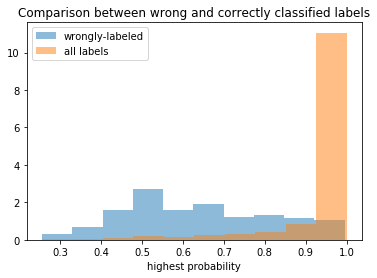

In [14]:
wrong_probs = np.array([prediction_probs[ind][digit] for ind,digit in zip(wrong_results,predictions[wrong_results])])
all_probs =  np.array([prediction_probs[ind][digit] for ind,digit in zip(np.arange(len(predictions)),predictions)])
#plot as histogram
plt.hist(wrong_probs,alpha=0.5,density=True,label='wrongly-labeled');
plt.hist(all_probs,alpha=0.5,density=True,label='all labels');
plt.legend();
plt.title('Comparison between wrong and correctly classified labels');
plt.xlabel('highest probability');

## What's been fitted ?
Let's look at the convolutional layer and the kernels that have been learnt.

In [15]:
print (model.layers[0].get_weights()[0].shape)

(3, 3, 1, 32)


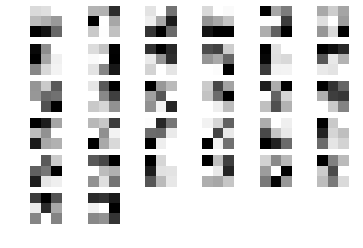

In [16]:
weights = model.layers[0].get_weights()[0]
for i in range(nb_filters):
    plt.subplot(6,6,i+1)
    plt.imshow(weights[:,:,0,i],cmap='gray',interpolation='none'); plt.axis('off');

## Visualising intermediate layers in the CNN
In order to visualise the activations half-way through the CNN and have some sense of what these convolutional kernels do to the input we need to create a new model with the same structure as before, but with the final layers missing. We then give it the weights it had previously and then predict on a given input. We now have a model that gives provides us as output the convolved input passed through the activation for each of the learnt filters (32 all together).

In [17]:
#Create new sequential model, same as before but just keep the convolutional layer. 
model_new = Sequential()
model_new.add(Conv2D(nb_filters, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) 

In [18]:
#set weights for new model from weights trained on MNIST.
for i in range(1):
    model_new.layers[i].set_weights(model.layers[i].get_weights())

In [19]:
#pick a random digit and "predict" on this digit (output will be first layer of CNN)
i = np.random.randint(0,len(x_test))
digit = x_test[i].reshape(1,28,28,1)
pred = model_new.predict(digit)

In [22]:
#check shape of prediction
print(pred.shape)

(1, 26, 26, 32)


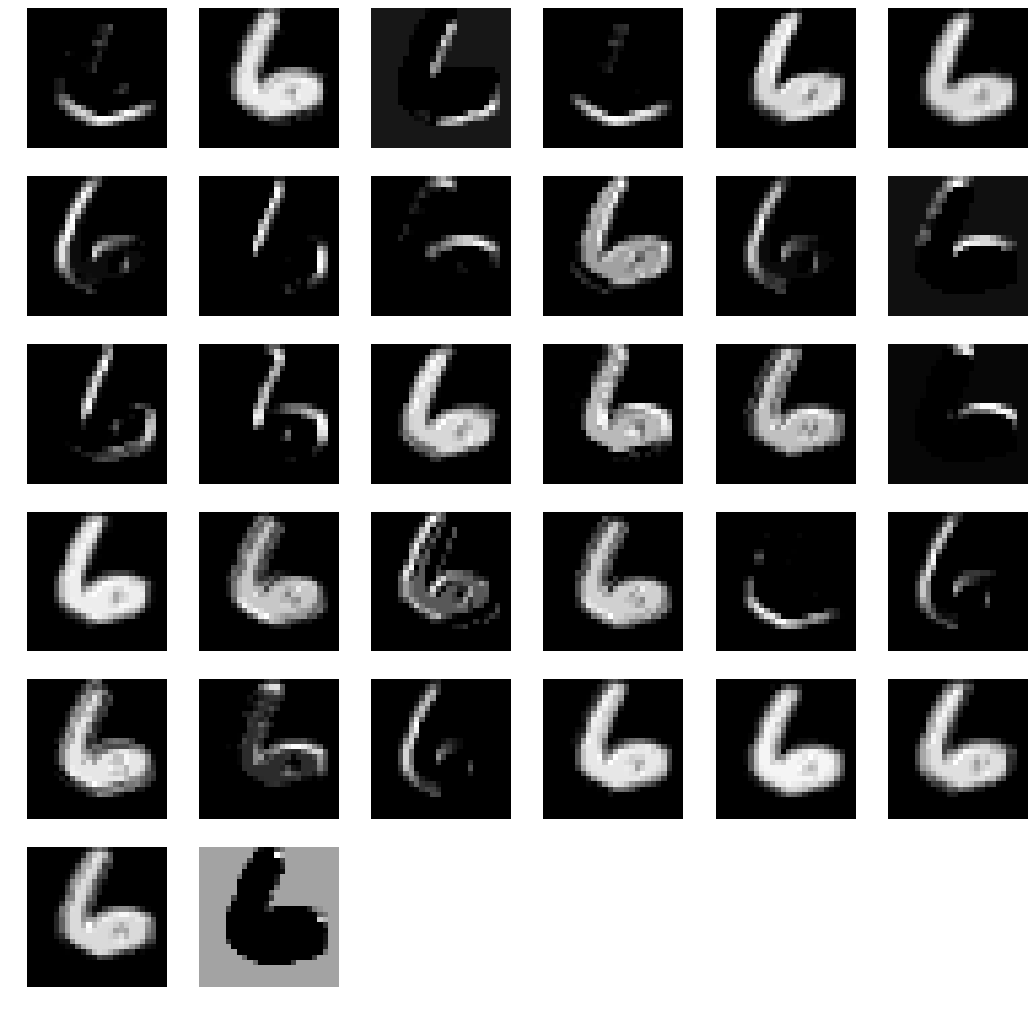

In [23]:
#For all the filters, plot the output of the input
plt.figure(figsize=(18,18))
filts = pred[0]
for i in range(nb_filters):
    filter_digit = filts[:,:,i]
    plt.subplot(6,6,i+1)
    plt.imshow(filter_digit,cmap='gray'); plt.axis('off');

# Appendix

The keras library is very flexible, constantly being updated and being further integrated with tensorflow. Some example scripts for keras can be found [here](https://github.com/fchollet/keras/tree/master/examples).

Another advantage is its intergration with [tensorboard](https://www.tensorflow.org/get_started/summaries_and_tensorboard): A visualisation tool for neural network learning and debugging. To start we need to install it. If you've installed tensorflow already then you should already have it (check with: `which tensorboard`). Otherwise, run the command:
```sh
pip install tensorflow
```

## Simple neural network 

We start by creating a simple neural network on a test dataset. First let's create and visualise the data

In [24]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

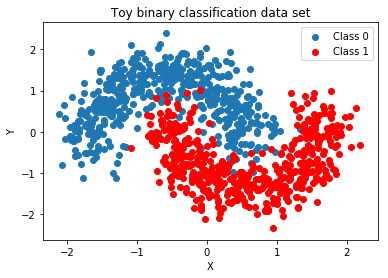

In [25]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

## Creating a neural network
We'll create a very simple multi-layer perceptron with one hidden layer.

In [26]:
#Create sequential  multi-layer perceptron
#uncomment if you want to add more layers (in the interest of time we use a shallower model)
model = Sequential()
model.add(Dense(32, input_dim=2,activation='relu')) #X,Y input dimensions. connecting to 8 neurons with relu activation
model.add(Dense(1, activation='sigmoid')) #binary classification so one output

model.compile(optimizer='AdaDelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Adding in a callback for tensorboard
Next we define a callback for the model. This basically tells keras what format and where to write the data such that tensorboard can read it 

In [27]:
tb_callback = keras.callbacks.TensorBoard(log_dir='./Graph/new3/', histogram_freq=0, write_graph=True, write_images=False)

Now perform model fitting. Note where we've added in the callback.

In [28]:
model.fit(X_train, Y_train, batch_size=16, epochs=30,
          verbose=0, validation_data=(X_test, Y_test),callbacks=[tb_callback])
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2764884948730469
Test accuracy: 0.8659999995231629


In [29]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
X, Y = grid
prediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=1)

10000/10000 [==============================] - 0s 12us/step


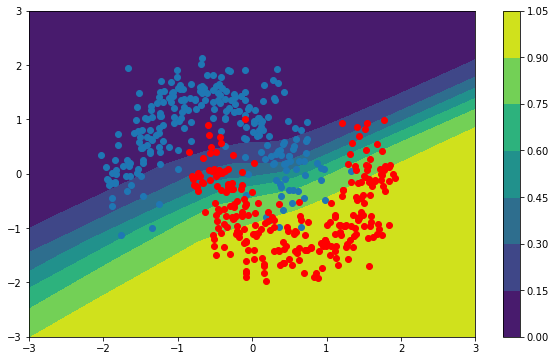

In [30]:
##plot results
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(X, Y, prediction_probs.reshape(100, 100))
ax.scatter(X_test[Y_test==0, 0], X_test[Y_test==0, 1])
ax.scatter(X_test[Y_test==1, 0], X_test[Y_test==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)

## Visualising results
Now we visualise the results by running the following in the same terminal as this script
```sh
tensorboard --logdir $(pwd)/Graph 
```

In [ ]:
! tensorboard --logdir $(pwd)/Graph